In [1]:
import pandas as pd
import warnings
from sklearn.linear_model import Ridge
import statsmodels.regression.linear_model as sm
import statsmodels.tools.tools as t
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Reading in the data
air_quality_dat = pd.read_csv("fetched_data/AIR_QUALITY_DATA.csv")

paris_agreement_dat = pd.read_csv("fetched_data/PARIS_AGREEMENT_DATA.csv")

greenhouse_gas_dat = pd.read_csv("fetched_data/GHG_DATA.csv")

In [3]:
# Merging all the data needed for analysis
merged_data = air_quality_dat.merge(paris_agreement_dat, how = "left", on = "Country_Name").merge(greenhouse_gas_dat, how = "left", left_on = ["Country_Name"], right_on = ["Country"])


In [4]:
# Selecting columns needed
simplified_data = merged_data[["Country_Name", "NO2", "GHG_Emissions", "Date_Joined"]].rename(columns = {"Date_Joined":"Paris_Status"})

In [5]:
warnings.filterwarnings('ignore')

### HERE is where I will do preprocessing to turn data joined variables such as a, AA, and R 
### into one-hot encoded variables

## Initially I thought that only small cities would be missing values, 
# however there seems to be larger cities with missing NO2/GHG values as well 
# so we will go with median imputation. Limitations of this method should be noted
simplified_data['NO2'] = simplified_data.groupby("Country_Name")['NO2'].transform(lambda x: x.fillna(x.median()))
simplified_data['GHG_Emissions'] = simplified_data.groupby("Country_Name")['GHG_Emissions'].transform(lambda x: x.fillna(x.median()))

In [6]:
# Group by 'Country' column
simplified_data_grouped = simplified_data.groupby('Country_Name')

# Drop rows where all NO2 values are null within each country group
simplified_data_minimal = simplified_data_grouped.filter(lambda x: x['NO2'].notna().any())

In [7]:
aggregated_data = simplified_data_minimal.groupby(['Country_Name',"GHG_Emissions","Paris_Status"]).sum().reset_index()

In [8]:
one_hot_encoded_data = pd.get_dummies(aggregated_data, columns = ['Paris_Status']) 
one_hot_encoded_data[['Paris_Status_A         ',
       'Paris_Status_AA        ', 'Paris_Status_None      ',
       'Paris_Status_R         ']] = one_hot_encoded_data[['Paris_Status_A         ',
       'Paris_Status_AA        ', 'Paris_Status_None      ',
       'Paris_Status_R         ']].astype(int)

In [9]:
X = one_hot_encoded_data.drop(columns = ["NO2","Country_Name"])
X = t.add_constant(X)
y = one_hot_encoded_data[["NO2"]]

In [10]:
result = sm.OLS(y, X).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.3296
Date:                Mon, 18 Mar 2024   Prob (F-statistic):              0.857
Time:                        12:49:51   Log-Likelihood:                -465.70
No. Observations:                  53   AIC:                             941.4
Df Residuals:                      48   BIC:                             951.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Adjusted R^2 value is -0.054.

Confidence intervals are:

Text(49.542774305555554, 0.5, 'NO2 Air Levels')

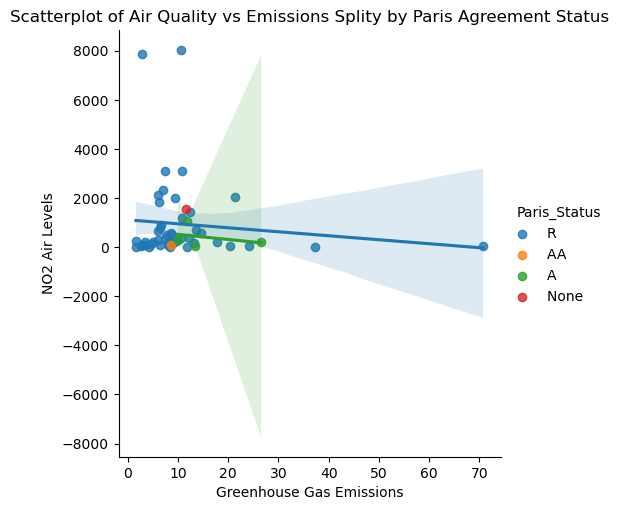

In [11]:
sns.lmplot(x='GHG_Emissions', y='NO2', hue="Paris_Status", data=aggregated_data)
ax = plt.gca()
ax.set_title("Scatterplot of Air Quality vs Emissions Splity by Paris Agreement Status")
ax.set_xlabel("Greenhouse Gas Emissions")
ax.set_ylabel("NO2 Air Levels")